Checking to see if there is any difference observed when we do the dem re-scaling either internal to demreg (where Iain originally implemented it) or externally as a final step before saving results.

It seems: no!


Note: to actually re-run this test, you need to go in and edit both the demreg code and dodem for the case where you're doing the rescale internally. Versions of the demreg files that do this are in the parent demreg directory, with the word 'rscl' added to their names. In addition to placing these in the python folder (named as demreg expects), you also need to change the calls in dodem to include "rscl=True", and account for the fact that the outputs will return more objects. 

In [1]:
# import matplotlib.pyplot as plt
# import numpy as np
# import glob
# from astropy.io import fits
# from astropy import units as u
# import importlib
# import pathlib

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

import nustar_dem_prep as nu
# import initial_analysis as ia
# import orbit_auto as oa
import time_interval_selection as tis
import nustar_utilities as nuutil
# import gauss2D as g2d
import all_nu_analysis as ana
import visualize_dem_results as viz
import images_and_coalignment as iac
import dem_rescale as dem_rscl


import pickle
import pathlib
import importlib
import numpy as np
import subprocess


In [2]:

def do_key_dem(key, missing_last=False, missing_orbit=4, plot_xrt=True, method='fit',
              high_temp_analysis=False):

    """
    Set missing_last=True to trim time interval list to exclude the last interval in an orbit (missing_orbit)
    (useful due to some NCCS AIA data intervals slightly shorter than NuSTAR intervals). 
    
    """


    #Path to top-level do-dem directory - edit for your system.
    path_to_dodem = '/Users/jmdunca2/do-dem/'

    with open('all_targets.pickle', 'rb') as f:
        data = pickle.load(f)

    ARDict = data[key]
    
    id_dirs = ARDict['datapaths']
    obsids = ARDict['obsids']
    working_dir = ARDict['working_dir']
    prepped_aia_dir = ARDict['prepped_aia']
    if method=='double':
        gauss_stats = ARDict['gauss_stats']
        sep_axis = gauss_stats[0][0]
    else:
        sep_axis = ''
        

    if method in ['input', 'double']:
        directories = ana.get_region_directories(key, method=method)
        all_all_time_intervals, fixit = tis.region_time_intervals(directories, id_dirs, shush=True)

    if method=='fit':
        onegauss=True
        regfile=path_to_dodem+'starter_region.reg'
        all_time_intervals, all_time_intervals_list = tis.find_all_intervals(working_dir, shush=True, 
                                                                        missing_last=missing_last, missing_orbit=missing_orbit)


    #What instruments are you using?
    #---------------------------------
    aia=True
    #---------------------------------
    eis=False
    xrt=True
    #This is where I'm putting my XRT level-1 data and grade maps:
    xrt_path=working_dir+'/XRT_for_DEM/'
    xrt=True
    from astropy import units as u
    exposure_dict={'Be_thin': [1*u.s, 10*u.s],
                    'Be_med': [],
                  'Al_poly': [0.1*u.s, 1*u.s]}
    #---------------------------------
    plot=False
    #---------------------------------
    nustar=True
    #If nustar is being used, here are the chosen energy ranges:
    nuenergies=[[2.5,3.5], [3.5,6.], [6.,10.]]
    nuradius=150
    #---------------------------------
    
    #---------------------------------
    #---------------------------------
    #What temperature range would you like to use? (units: log(T))
    minT=5.6
    maxT=7.2
    
    #Would you prefer to plot temperatures in MK, or the default (logT)
    plotMK=False
    #---------------------------------
    #---------------------------------
    
    name=key+'_internal_rescale_'
    
    import dodem
    import glob
    
    for o in range(0, len(obsids)):
    
        datapath=id_dirs[o]
        xrt_path=path_to_dodem+'other_idl/'+obsids[o]+'_coobs/XRT_for_DEM/'
        if not pathlib.Path(xrt_path).is_dir():
            xrt=False
        gtifile=datapath+'event_cl/nu'+obsids[o]+'A06_gti.fits'
        orbit_aia_dir = prepped_aia_dir+'/orbit_'+obsids[o]+'/'
        obsid=obsids[o]

        if method=='fit':
            guess = ARDict['gauss_stats'][o][0]
            time_intervals = all_time_intervals[o]    
            for time in time_intervals:

                print(orbit_aia_dir)
                data, bl, tr, region_input = iac.read_interval_dicts(time, where=orbit_aia_dir, bltr=True)
                #print('data: ', data)
                #print(data['aia_dn_s_px'])

                if high_temp_analysis:
                    dodem.high_temp_analysis(time, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name2=name,
                                                   plotMK=plotMK, highT=7.2, #(minT, maxT are varied)
                                                   working_directory=working_dir, #(plotresp set false in high_temp_analysis)
                                                   default_err=0.2, path_to_dodem=path_to_dodem,
                                                   demmethod='DEMREG', use_prior_prep=True,
                            
                                                   #demreg/xrt_iterative related
                                                   rgt_fact=1.2, max_iter=30, 
                                                   reg_tweak=1, #mc_in, mc_rounds hard coded in high_temp_analysis (same as below)
                            
                                                   #nustar=related
                                                   nuenergies = nuenergies, #combine_fpm hard coded in high_temp_analysis (same as below)
                                                   datapath=datapath, gtifile=gtifile, 
                                                   nuradius=nuradius, guess=guess, onegauss=onegauss,
                                                   adjacent_grades=True, pile_up_corr=True,
                                                   force_nustar=True,
                                             
                                                   #aia related
                                                   load_prepped_aia=data, 
                            
                                                   #xrt related
                                                   xrtmethod='Average', real_xrt_err=True, xrt_path=xrt_path,
                                                   xrt_exposure_dict = exposure_dict, plot=plot_xrt, #(this plots xrt)
                                                   input_xrt_region="circle", input_xrt_region_dict=region_input)
                    


                else:
                    dodem.dodem(time, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name=name,
                                            plotMK=plotMK, minT=minT, maxT=maxT,
                                            plotresp=False, working_directory=working_dir,
                                            default_err=0.2, path_to_dodem=path_to_dodem,
                    
                                            #demreg related
                                            rgt_fact=1.2, max_iter=30,
                                            reg_tweak=1, mc_in=True, mc_rounds=100, 
                                            
                                            #nustar related 
                                            combine_fpm=True, nuenergies=nuenergies, 
                                            datapath=datapath, gtifile=gtifile,
                                            nuradius=nuradius, guess=guess, onegauss=onegauss,
                                            adjacent_grades=True, pile_up_corr=True,
                                            force_nustar=True,
                    
                                            #aia related
                                            load_prepped_aia=data, 
        
                                            #xrt related
                                           xrtmethod='Average', real_xrt_err=True, xrt_path=xrt_path,
                                            xrt_exposure_dict=exposure_dict, plot_xrt=plot_xrt,
                                            input_xrt_region="circle", input_xrt_region_dict=region_input)
        print('')

        if method in ['input', 'double']:
            fpm='A'
            if method=='input':
                regfiles = glob.glob(working_dir+'gauss_cen_'+obsid+'_'+fpm+'_user_input*.reg')
            if method=='double':
                regfiles = glob.glob(working_dir+'gauss_cen_'+obsid+'_'+fpm+'_*.reg')
                
            regfiles.sort()
            
            for i in range(0, len(directories)):
                #Time intervals for this region, orbit
                time_intervals = all_all_time_intervals[i][o]

                regfile = regfiles[i]
                print(directories[i], regfiles[i])

                for time in time_intervals:
                    res = iac.read_interval_dicts(time, where=orbit_aia_dir, bltr=True)
                    if res is None:
                        continue
                    datas, bl, tr, xrt_region_inputs = res
                    data = datas['region'+str(i)]
                    region_input = xrt_region_inputs[i]

                    if high_temp_analysis:
                        dodem.high_temp_analysis(time, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name2=name,
                                                plotMK=plotMK, highT=7.2, #(minT, maxT are varied)
                                                working_directory=directories[i], #(plotresp set false in high_temp_analysis)
                                                default_err=0.2, path_to_dodem=path_to_dodem,
                                                demmethod='DEMREG', use_prior_prep=True,

                                 
                                                #demreg/xrt_iterative related
                                                rgt_fact=1.2, max_iter=30, 
                                                reg_tweak=1, #mc_in, mc_rounds hard coded in high_temp_analysis (same as below)

                            
                                                #nustar=related
                                                nuenergies = nuenergies, #combine_fpm hard coded in high_temp_analysis (same as below)
                                                datapath=datapath, gtifile=gtifile, 
                                                nuradius=nuradius, edit_regfile=False,
                                                regfile=regfile,
                                                adjacent_grades=True, pile_up_corr=True,
                                                force_nustar=True,

                                                #aia related
                                                load_prepped_aia=data, 

                                                #xrt related
                                                xrtmethod='Average', real_xrt_err=True, xrt_path=xrt_path,
                                                xrt_exposure_dict=exposure_dict, plot=plot_xrt, #(this plots xrt)
                                                input_xrt_region="circle", input_xrt_region_dict=region_input)



                                                 
                    else:
                        picklefile = dodem.dodem(time, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name=name,
                                            plotMK=plotMK, minT=minT, maxT=maxT,
                                            plotresp=False, working_directory=directories[i],
                                            default_err=0.2, path_to_dodem=path_to_dodem,
                    
                                            #demreg related
                                            rgt_fact=1.2, max_iter=30,
                                            reg_tweak=1, mc_in=True, mc_rounds=100, 
                                            
                                            #nustar related 
                                            combine_fpm=True, nuenergies=nuenergies, 
                                            datapath=datapath, gtifile=gtifile,
                                            nuradius=nuradius, edit_regfile=False,
                                            regfile=regfile,
                                            adjacent_grades=True, pile_up_corr=True,
                                            force_nustar=True,
                    
                                            #aia related
                                            load_prepped_aia=data, 
                
                                            #xrt related
                                           xrtmethod='Average', real_xrt_err=True, xrt_path=xrt_path,
                                            xrt_exposure_dict=exposure_dict, plot_xrt=plot_xrt,
                                            input_xrt_region="circle", input_xrt_region_dict=region_input)


                        return picklefile


In [3]:
importlib.reload(ana)
key = '26-jul-16_2'

#===============================================================
#Update dictionary to have correct aia path for NCCS-prepped data.
#===============================================================
with open('all_targets.pickle', 'rb') as f:
    data = pickle.load(f)

ARDict = data[key]

id_dirs = ARDict['datapaths']
obsids = ARDict['obsids']
working_dir = ARDict['working_dir']
method = ARDict['method']

ARDict['prepped_aia'] = working_dir+'all_aia_dicts_'+key+'_post/'

data[key] = ARDict

with open('all_targets.pickle', 'wb') as f:
         # Pickle the 'data' dictionary using the highest protocol available.
         pickle.dump(data, f, pickle.HIGHEST_PROTOCOL) 

#===============================================================
#DO DEMS


for id in id_dirs:
    evt_data, hdr = nu.return_submap(datapath=id, fpm='A', return_evt_hdr=True)
    time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
    timerange = [time0, time1]
    print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))

picklefile = do_key_dem(key, plot_xrt=False, method=method, high_temp_analysis=False) #missing_last=True, missing_orbit=1, plot_xrt=False)

#===============================================================




23-26-59 23-36-53

/Users/jmdunca2/do-dem/initial_dem_26jul16_2/region_0/ /Users/jmdunca2/do-dem/initial_dem_26jul16_2/gauss_cen_20201006001_A_user_input_0.reg
Start Time:  2016-07-26 23:27:00
Stop Time:  2016-07-26 23:36:50

Using input regfile:
/Users/jmdunca2/do-dem/initial_dem_26jul16_2/gauss_cen_20201006001_A_user_input_0.reg
Using grades 0-4 NuSTAR events.
ARF File:  ['/Users/jmdunca2/do-dem/initial_dem_26jul16_2/region_0/23-27-00_23-36-50/nu20201006001A06_0_4_p_sr.arf']
RMF File:  ['/Users/jmdunca2/do-dem/initial_dem_26jul16_2/region_0/23-27-00_23-36-50/nu20201006001A06_0_4_p_sr.rmf']
PHA File:  ['/Users/jmdunca2/do-dem/initial_dem_26jul16_2/region_0/23-27-00_23-36-50/nu20201006001A06_0_4_p_sr.pha']
ARF File:  ['/Users/jmdunca2/do-dem/initial_dem_26jul16_2/region_0/23-27-00_23-36-50/nu20201006001A06_21_24_p_sr.arf']
RMF File:  ['/Users/jmdunca2/do-dem/initial_dem_26jul16_2/region_0/23-27-00_23-36-50/nu20201006001A06_21_24_p_sr.rmf']
PHA File:  ['/Users/jmdunca2/do-dem/initial_de

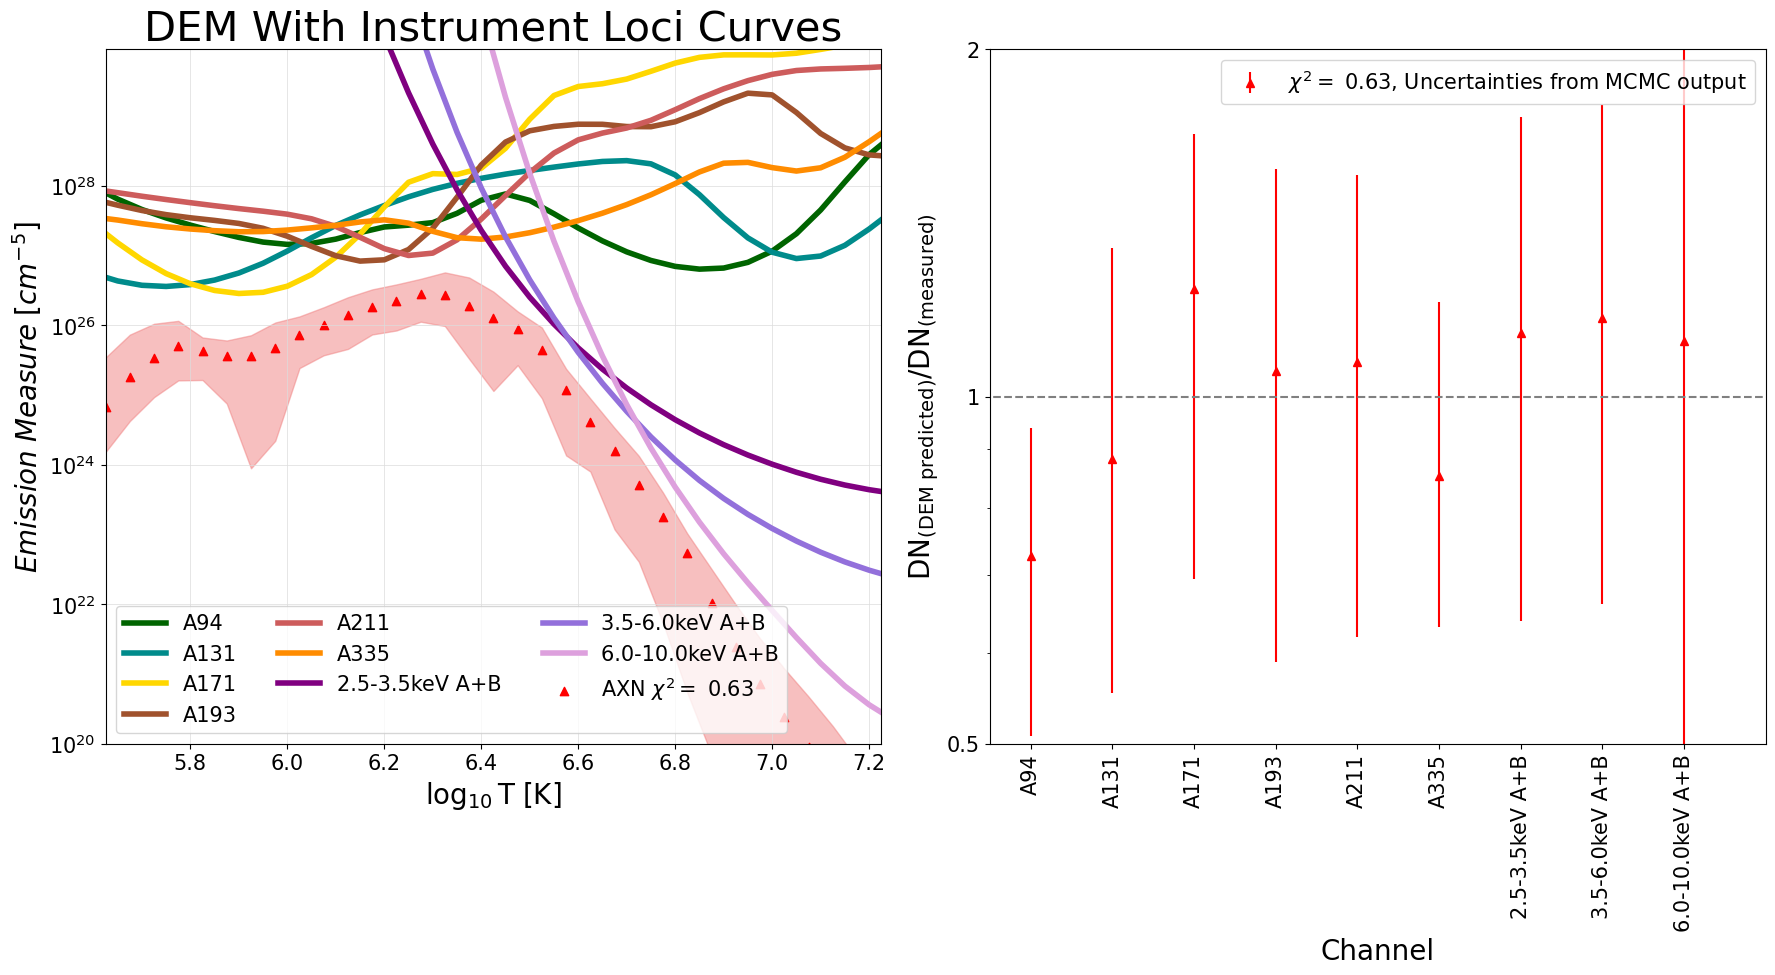

In [4]:
importlib.reload(viz)

data, timestring, time = viz.load_DEM(picklefile)
viz.plot_DEM(data, title='', plotMK=False, fill_color='lightcoral', show=True)

Rescaled by:  1.205515818498692


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

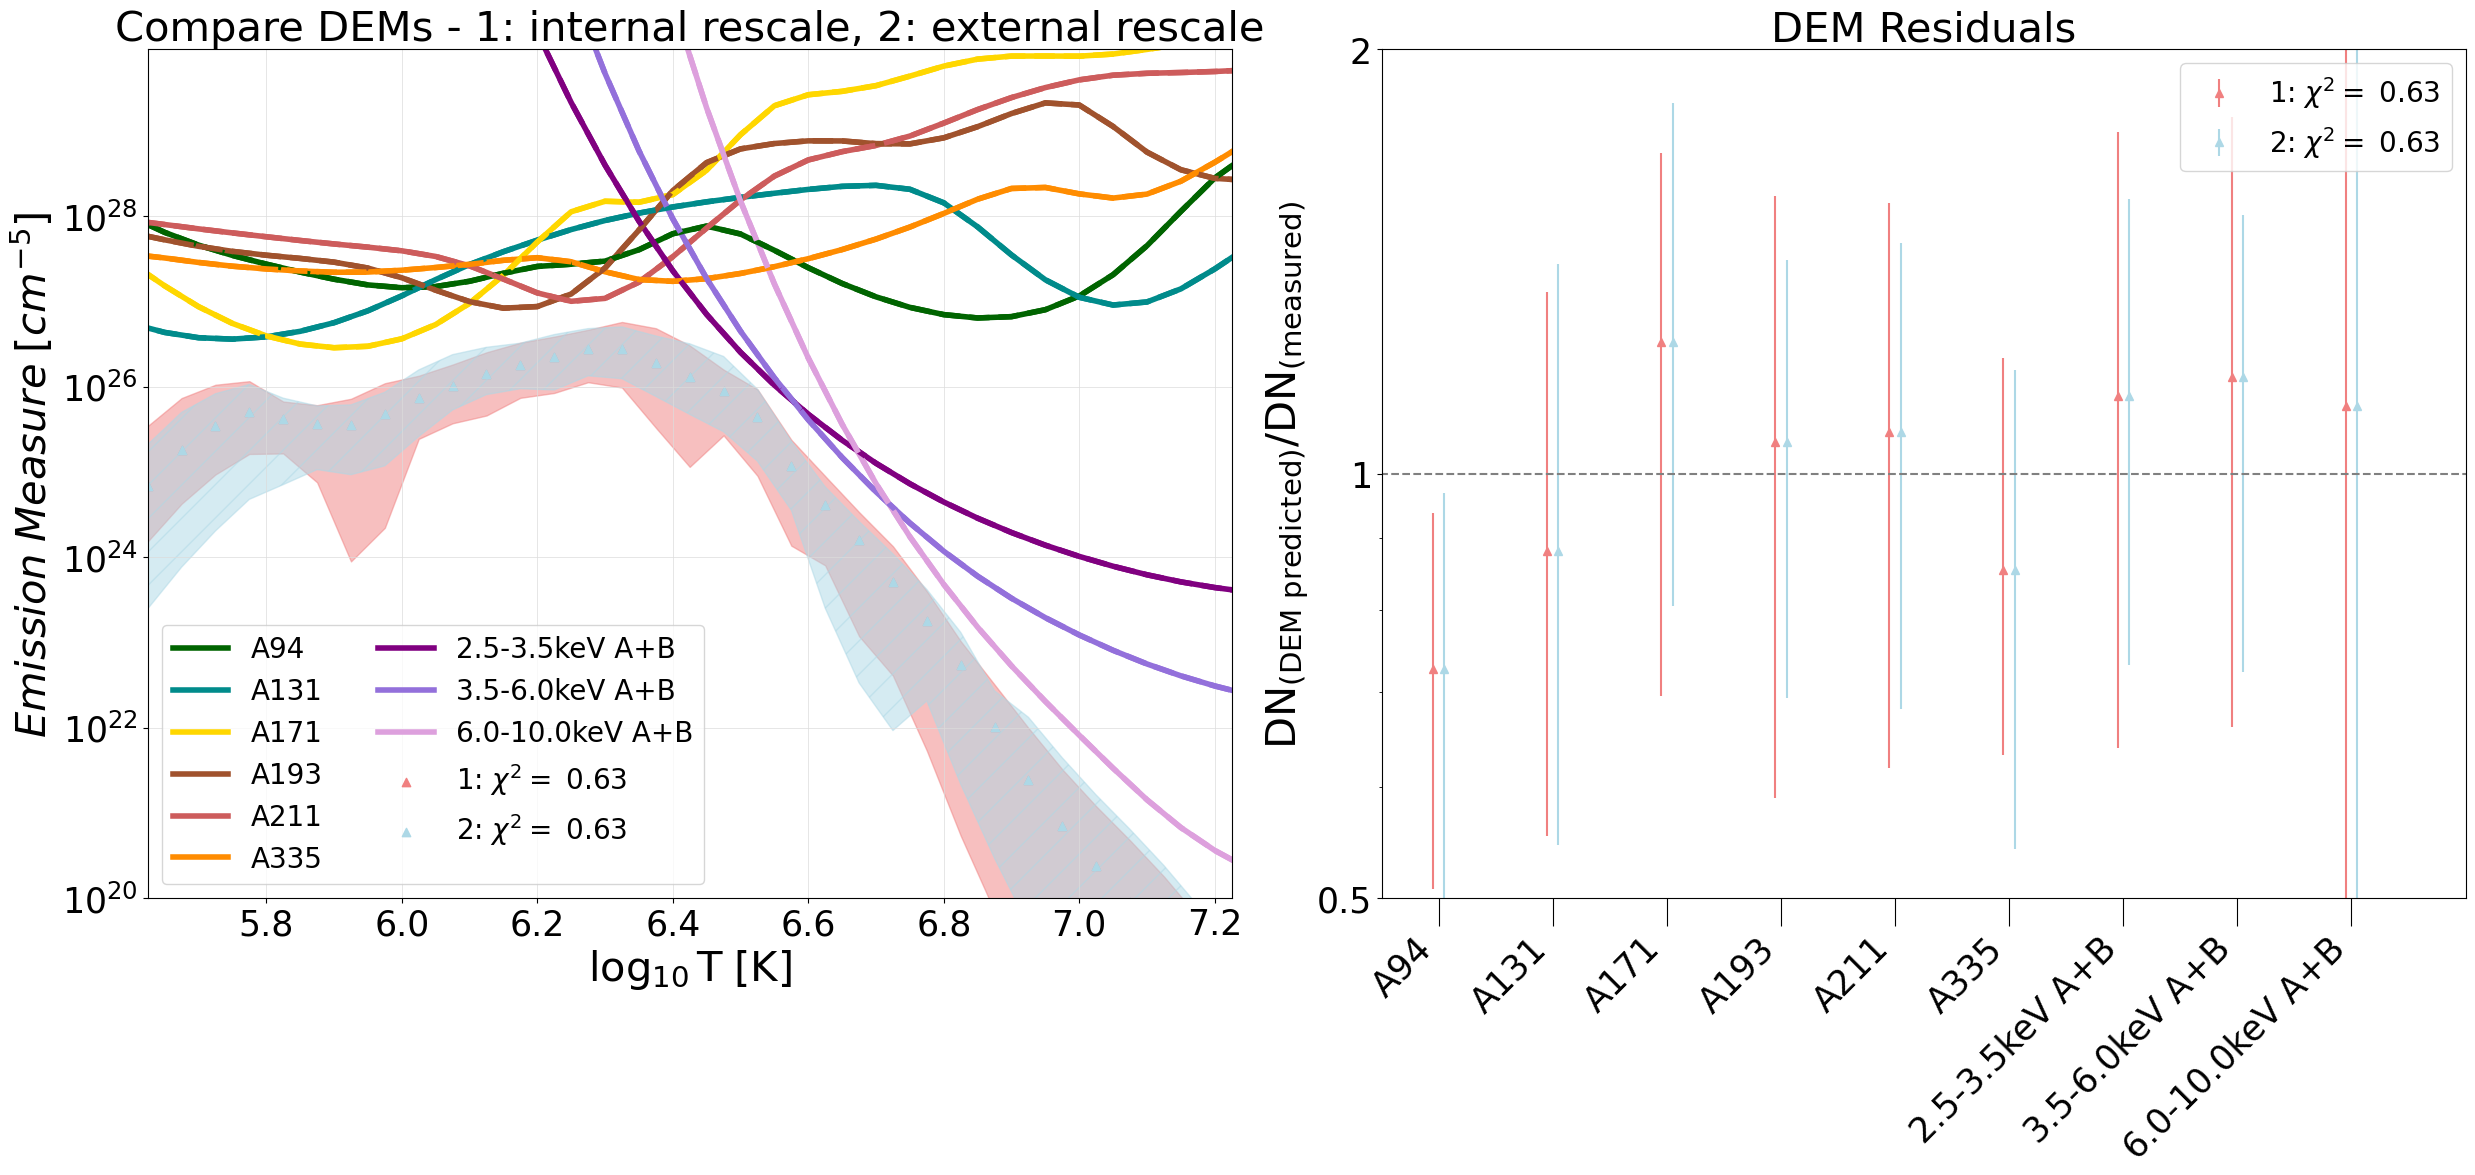

In [6]:
og = '/Users/jmdunca2/do-dem/initial_dem_26jul16_2/region_0/23-27-00_23-36-50/23-27-00_23-36-50_5.6_7.2_26-jul-16_2_MC_DEM_result.pickle'
ogdata, timestring, time = viz.load_DEM(og)

newdata = dem_rscl.do_rescale(ogdata, rscl_factor=[])

viz.compare_DEMs(data, newdata, timestring, timestring, title1='internal rescale', title2='external rescale', plotMK=False, plot=True,
                working_dir='./')